In [14]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Data preparation

In [4]:
smiles = "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"
tokenizer = BasicSmilesTokenizer()
tokens = tokenizer.tokenize(smiles)
print("Tokenized SMILES:", tokens)

Tokenized SMILES: ['C', 'C', '(', 'C', ')', 'C', 'C', '1', '=', 'C', 'C', '=', 'C', '(', 'C', '=', 'C', '1', ')', 'C', '(', 'C', ')', 'C', '(', '=', 'O', ')', 'O']


In [5]:
# Load pd_train
pd_train = pd.read_csv("data_smiles/Training_Group.csv")
pd_train["label"] = pd_train["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)
pd_train["label"].value_counts()
print(pd_train.head())

(1241, 3)
                                              Smiles           Liver  label
0                              S=C=Nc1c2c(ccc1)cccc2  Hepatotoxicity      1
1  c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...  Hepatotoxicity      1
2            c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O  Hepatotoxicity      1
3                                           O(CCO)CC  Hepatotoxicity      1
4                                  Oc1cc2c(cc1)cccc2  Hepatotoxicity      1


In [ ]:
# Load pd_test
pd_test = pd.read_csv("data_smiles/Testing_Group.csv")
pd_test["label"] = pd_test["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)
pd_test["label"].value_counts()
print(pd_test.head())

(286, 3)
                                              Smiles           Liver  label
0  C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN...  Hepatotoxicity      1
1                      C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl  Hepatotoxicity      1
2  CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(...  Hepatotoxicity      1
3         C1CC2=CC=CC=C2C(C3=CC=CC=C31)NCCCCCCC(=O)O  Hepatotoxicity      1
4          C1=CC=C(C=C1)CN2C3=CC=CC=C3C(=N2)OCC(=O)O  Hepatotoxicity      1


In [8]:
pd_train["dataset"] = "train"
pd_test["dataset"] = "test"
data = pd.concat([pd_train, pd_test])
print(data.shape)
data["dataset"].value_counts()

(1527, 4)


dataset
train    1241
test      286
Name: count, dtype: int64

## Atom frequency

In [19]:
# Tokenize SMILES strings and calculate token frequencies
data['Tokenized'] = data['Smiles'].apply(lambda x: tokenizer.tokenize(x))
data['TokenCounts'] = data['Tokenized'].apply(lambda x: dict(Counter(x)))
print("Tokenized SMILES with Frequency Counts:\n", data[['Smiles', 'Tokenized', 'TokenCounts']].head(1))

Tokenized SMILES with Frequency Counts:
                   Smiles                                          Tokenized  \
0  S=C=Nc1c2c(ccc1)cccc2  [S, =, C, =, N, c, 1, c, 2, c, (, c, c, c, 1, ...   

                                         TokenCounts  
0  {'S': 1, '=': 2, 'C': 1, 'N': 1, 'c': 10, '1':...  


In [22]:
# Get all unique tokens across all SMILES strings
all_tokens = set(token for tokens in data['Tokenized'] for token in tokens)

# Create a frequency vector for each SMILES string
def create_frequency_vector(token_counts, all_tokens):
    return [token_counts.get(token, 0) for token in all_tokens]

# Apply to create frequency vectors
data['FrequencyVector'] = data['TokenCounts'].apply(lambda x: create_frequency_vector(x, all_tokens))
data['FrequencyVector']

0      [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1      [0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2      [0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3      [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4      [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                             ...                        
281    [1, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
282    [0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
283    [0, 0, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
284    [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
285    [1, 0, 2, 30, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,...
Name: FrequencyVector, Length: 1527, dtype: object

In [24]:
# Convert frequency vectors to a 2D NumPy array for model training
X_train = np.array(data[data['dataset'] == 'train']["FrequencyVector"].tolist())
y_train = data[data['dataset'] == 'train']["label"].values

X_test = np.array(data[data['dataset'] == 'test']["FrequencyVector"].tolist())
y_test = data[data['dataset'] == 'test']["label"].values

print(X_train.shape, y_train.shape)

(1241, 51) (1241,)


# Model training

In [25]:
from tpot import TPOTClassifier

# Set up TPOT with basic configuration
tpot = TPOTClassifier(
    generations=10,
    population_size=40,
    verbosity=2,
    scoring="roc_auc",  # AUC
    random_state=42,
    n_jobs=6,  # Use 4 cores
)

# Fit the model
tpot.fit(X_train, y_train)

c:\Users\predator\anaconda3\envs\dili-tmp\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


                                                                              
Generation 1 - Current best internal CV score: 0.6975227798260752
                                                                              
Generation 2 - Current best internal CV score: 0.6975227798260752
                                                                              
Generation 3 - Current best internal CV score: 0.6990878122801696
                                                                              
Generation 4 - Current best internal CV score: 0.6990878122801696
                                                                              
Generation 5 - Current best internal CV score: 0.6990878122801696
                                                                              
Generation 6 - Current best internal CV score: 0.7012602451712585
                                                                              
Generation 7 - Current best internal CV score: 0.70

TPOTClassifier(generations=10, n_jobs=6, population_size=40, random_state=42,
               scoring='roc_auc', verbosity=2)

In [26]:
# calculate accuracy
test_set_acc = tpot.score(X_test, y_test)
print("Evaluation on validation and test set:")
print(f"Accuracy: {test_set_acc}")

Evaluation on validation and test set:
Accuracy: 0.67518273581622


In [27]:
# calculate precision, recall
from sklearn.metrics import precision_score, recall_score

y_test_hat = tpot.predict(X_test)
precision = precision_score(y_test, y_test_hat)
recall = recall_score(y_test, y_test_hat)
print(f"Precision: {precision:.3f}\tRecall: {recall:.3f}")

Precision: 0.851	Recall: 0.670


<Axes: >

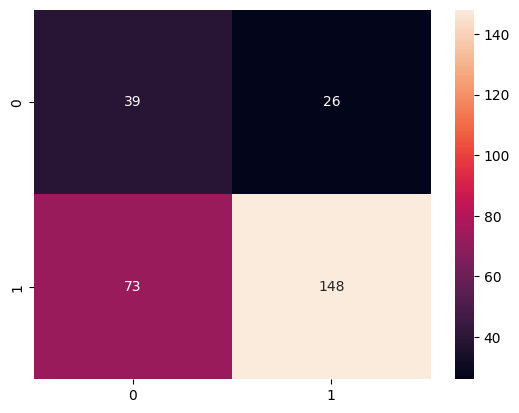

In [29]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_test_hat)
sns.heatmap(cm, annot=True, fmt="d")